## Define Hypotheses

1. What kind of patients were admitted to the ICU? In terms of history, age, etc.
2. What was the total caregiver-to-patient ratio? Per department?
3. How many medical students worked with patients? How many patients per student?

### Determine what kind of datasets would help answer the hypotheses

## Import Libraries

In [1]:
# Import libraries
import os, os.path
import shutil

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

In [2]:
# Library Versions

import matplotlib

print("Pandas version: ", pd.__version__)
print("Matplotlib version: ", matplotlib.__version__)

Pandas version:  1.0.1
Matplotlib version:  3.1.3


In [3]:
# Library Options

pd.options.mode.chained_assignment = None  # default='warn'

## Load Data

In [4]:
# Load Data
csv_folder = r'C:\Users\rmutalik\Desktop\mimic-iii-clinical-database-1.4'
df_dict = {}
df_large = {}
large_files = []

# Loop through all files in folders
for file in os.listdir(csv_folder):
    
    if file.endswith(".csv"):
        name = os.path.splitext(file)[0]

        # If file size is greater than ~100MB, skip it
        MAX_FILE_SIZE = 100000000
        physical_file = os.path.join(csv_folder, file)
        statinfo = os.stat(physical_file)
#         print(statinfo)            
        if statinfo.st_size > MAX_FILE_SIZE:
            large_files.append(file)
            standardized_size = statinfo.st_size / (10**6)
            print(file, standardized_size, "MB")
            
            df_chunk = pd.read_csv(physical_file, chunksize=1000000)
            chunk_list = []
            for chunk in df_chunk:
                chunk_list.append(chunk)
                # 10 chunks of data (10 million records) takes my hardware about 45 seconds to load ~ 1 GB of memory
                if len(chunk_list) > 5:
                    break
            df_large[name] = pd.concat(chunk_list)
            break
        else:
            df_dict[name] = pd.read_csv(physical_file)

CHARTEVENTS.csv 35307.895134 MB


In [5]:
print(df_large.keys())

# CHARTEVENTS.csv has 400 million records...it will take time to load that data
print(large_files)

print(len(df_large['CHARTEVENTS']))

dict_keys(['CHARTEVENTS'])
['CHARTEVENTS.csv']
6000000


In [6]:
df_large['CHARTEVENTS'].info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 6000000 entries, 0 to 5999999
Data columns (total 15 columns):
 #   Column        Dtype  
---  ------        -----  
 0   ROW_ID        int64  
 1   SUBJECT_ID    int64  
 2   HADM_ID       int64  
 3   ICUSTAY_ID    float64
 4   ITEMID        int64  
 5   CHARTTIME     object 
 6   STORETIME     object 
 7   CGID          float64
 8   VALUE         float64
 9   VALUENUM      float64
 10  VALUEUOM      object 
 11  WARNING       int64  
 12  ERROR         int64  
 13  RESULTSTATUS  float64
 14  STOPPED       float64
dtypes: float64(6), int64(6), object(3)
memory usage: 686.6+ MB


In [7]:
df_dict.keys()

dict_keys(['ADMISSIONS', 'CALLOUT', 'CAREGIVERS'])

In [8]:
from sys import getsizeof

# ERROR: Prints size of dictionary, which is 240 bytes. Does not print the size of the values inside
print("df_dict size: ", getsizeof(df_dict), "bytes")
print("df_large size: ", getsizeof(df_large), "bytes")

df_dict size:  240 bytes
df_large size:  240 bytes


## Explore Data

In [9]:
df_admissions = df_dict['ADMISSIONS']

In [10]:
df_admissions.head()

,ROW_ID,SUBJECT_ID,HADM_ID,ADMITTIME,DISCHTIME,DEATHTIME,ADMISSION_TYPE,ADMISSION_LOCATION,DISCHARGE_LOCATION,INSURANCE,LANGUAGE,RELIGION,MARITAL_STATUS,ETHNICITY,EDREGTIME,EDOUTTIME,DIAGNOSIS,HOSPITAL_EXPIRE_FLAG,HAS_CHARTEVENTS_DATA
0,21,22,165315,2196-04-09 12:26:00,2196-04-10 15:54:00,NaN,EMERGENCY,EMERGENCY ROOM ADMIT,DISC-TRAN CANCER/CHLDRN H,Private,NaN,UNOBTAINABLE,MARRIED,WHITE,2196-04-09 10:06:00,2196-04-09 13:24:00,BENZODIAZEPINE OVERDOSE,0,1
1,22,23,152223,2153-09-03 07:15:00,2153-09-08 19:10:00,NaN,ELECTIVE,PHYS REFERRAL/NORMAL DELI,HOME HEALTH CARE,Medicare,NaN,CATHOLIC,MARRIED,WHITE,NaN,NaN,CORONARY ARTERY DISEASE\CORONARY ARTERY BYPASS...,0,1
2,23,23,124321,2157-10-18 19:34:00,2157-10-25 14:00:00,NaN,EMERGENCY,TRANSFER FROM HOSP/EXTRAM,HOME HEALTH CARE,Medicare,ENGL,CATHOLIC,MARRIED,WHITE,NaN,NaN,BRAIN MASS,0,1
3,24,24,161859,2139-06-06 16:14:00,2139-06-09 12:48:00,NaN,EMERGENCY,TRANSFER FROM HOSP/EXTRAM,HOME,Private,NaN,PROTESTANT QUAKER,SINGLE,WHITE,NaN,NaN,INTERIOR MYOCARDIAL INFARCTION,0,1
4,25,25,129635,2160-11-02 02:06:00,2160-11-05 14:55:00,NaN,EMERGENCY,EMERGENCY ROOM ADMIT,HOME,Private,NaN,UNOBTAINABLE,MARRIED,WHITE,2160-11-02 01:01:00,2160-11-02 04:27:00,ACUTE CORONARY SYNDROME,0,1


In [11]:
df_admissions.info()
df_admissions.describe()
df_admissions.isna().sum()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 58976 entries, 0 to 58975
Data columns (total 19 columns):
 #   Column                Non-Null Count  Dtype 
---  ------                --------------  ----- 
 0   ROW_ID                58976 non-null  int64 
 1   SUBJECT_ID            58976 non-null  int64 
 2   HADM_ID               58976 non-null  int64 
 3   ADMITTIME             58976 non-null  object
 4   DISCHTIME             58976 non-null  object
 5   DEATHTIME             5854 non-null   object
 6   ADMISSION_TYPE        58976 non-null  object
 7   ADMISSION_LOCATION    58976 non-null  object
 8   DISCHARGE_LOCATION    58976 non-null  object
 9   INSURANCE             58976 non-null  object
 10  LANGUAGE              33644 non-null  object
 11  RELIGION              58518 non-null  object
 12  MARITAL_STATUS        48848 non-null  object
 13  ETHNICITY             58976 non-null  object
 14  EDREGTIME             30877 non-null  object
 15  EDOUTTIME             30877 non-null

ROW_ID                      0
SUBJECT_ID                  0
HADM_ID                     0
ADMITTIME                   0
DISCHTIME                   0
DEATHTIME               53122
ADMISSION_TYPE              0
ADMISSION_LOCATION          0
DISCHARGE_LOCATION          0
INSURANCE                   0
LANGUAGE                25332
RELIGION                  458
MARITAL_STATUS          10128
ETHNICITY                   0
EDREGTIME               28099
EDOUTTIME               28099
DIAGNOSIS                  25
HOSPITAL_EXPIRE_FLAG        0
HAS_CHARTEVENTS_DATA        0
dtype: int64

In [12]:
df_dict['CAREGIVERS'].head()

,ROW_ID,CGID,LABEL,DESCRIPTION
0,2228,16174,RO,Read Only
1,2229,16175,RO,Read Only
2,2230,16176,Res,Resident/Fellow/PA/NP
3,2231,16177,RO,Read Only
4,2232,16178,RT,Respiratory


In [13]:
df_dict['CAREGIVERS']['LABEL'].unique()

array(['RO', 'Res', 'RT', 'Rehab', 'MD', 'CM', 'RN', 'SW', 'RPH', 'MDs',
       'NP', 'RPh', 'SRT', 'RD', 'PCT', 'CoWork', 'Admin', 'CoWker',
       'UCO', 'PC', 'co-wor', 'RRT', 'MS', 'RTH', 'DI', 'SNP', 'ISOPS',
       'Med ST', 'ISSupp', 'CoWkr', 'RNC', 'PCA', 'HMSIV', 'MedSty', 'UA',
       'UC', 'RA', 'NEOB', 'Rn', 'RRts', 'Studen', 'LICSW', 'U A',
       'StPHa', 'CoOPSt', 'MedStu', 'PT', 'MedSt', 'Intern', 'StNurs',
       'rn', nan, 'AR', 'PHD', 'Dr', 'Fell', 'PA', 'H', 'St', 'IMD',
       'CoOpSt', 'CRT', 'SN', 'Medst', 'MSIV', 'STD', 'ajm', 'OTR/L',
       'Stu', 'RNs', 'R.Ph', 'PhStud', 'NSV', 'MSI', 'AL', 'MEDST', 'ms',
       'SRN', 'Nurs', 'Ms', 'Mds', 'NS', 'eaw', 'StNRS', 'PhD', 'MedRes',
       'NsgSt', 'RTSt', 'Coord', 'DR', 'RES', 'NuStud', 'PharmD', 'md',
       'RTStu', 'Prog', 'ReschA', 'CRA', 'PHaD', 'RN,RPh', 'ISSUPP',
       'Stud', 'Rph', 'CoOpst', 'MedSt.', 'Co-Wor', 'CRS', 'PhaD', 'Md',
       'DietIn', 'D', 'CCP', 'CoRN', 'ReAssi', 'DPM', 'RTS', '1390',
   

In [14]:
df_dict['CAREGIVERS']['DESCRIPTION'].unique()

array(['Read Only', 'Resident/Fellow/PA/NP', 'Respiratory',
       'Rehabilitation', nan, 'Case Manager', 'RN', 'Attending',
       'Social Worker', 'Pharmacist', 'Dietitian', 'PCT/NA',
       'Administrator', 'Pastoral Care', 'Research Assistant', 'UCO',
       'IMD'], dtype=object)

### Explore resident caregivers

In [15]:
residents = df_dict['CAREGIVERS'][ df_dict['CAREGIVERS']['DESCRIPTION'] == 'Resident/Fellow/PA/NP' ]

residents['LABEL'].unique()

array(['Res', 'MDs', 'MD', 'MS', 'Intern', 'Fell', 'PA', 'NP', 'ajm',
       'ms', 'STD', 'Ms', 'Mds', 'eaw', 'MedStu', 'MedRes', 'RN', 'RRT',
       '1390', 'Std', '9596', 'Med St', '3874', 'HMS MS', 'DML', 'MDS',
       'Studen', 'RF'], dtype=object)

In [16]:
residents_label = residents['LABEL'].to_dict().fromkeys(['MS','Intern','ms','STD','Ms','Mds',
                                               'MedStu','Std','Med St','MDS','Studen'], 
                                'student')

residents_label

{'MS': 'student',
 'Intern': 'student',
 'ms': 'student',
 'STD': 'student',
 'Ms': 'student',
 'Mds': 'student',
 'MedStu': 'student',
 'Std': 'student',
 'Med St': 'student',
 'MDS': 'student',
 'Studen': 'student'}

In [17]:
residents.replace(residents_label, inplace=True)

In [18]:
residents['LABEL'].unique()

array(['Res', 'MDs', 'MD', 'student', 'Fell', 'PA', 'NP', 'ajm', 'eaw',
       'MedRes', 'RN', 'RRT', '1390', '9596', '3874', 'HMS MS', 'DML',
       'RF'], dtype=object)

#### Remove values with unknown Label and only 1 record

In [19]:
r_vc = residents['LABEL'].value_counts()

r_vc

Res        1219
MD          148
MDs         125
student      31
RN            4
NP            4
PA            4
9596          1
eaw           1
Fell          1
1390          1
RF            1
ajm           1
RRT           1
3874          1
HMS MS        1
MedRes        1
DML           1
Name: LABEL, dtype: int64

In [20]:
residents.groupby('LABEL').filter(lambda x: len(x) == 1)['LABEL'].to_numpy()
# residents[residents['LABEL'].isin(r_vc[r_vc == 1].index)]['LABEL'].values   # Does same thing

array(['Fell', 'ajm', 'eaw', 'MedRes', 'RRT', '1390', '9596', '3874',
       'HMS MS', 'DML', 'RF'], dtype=object)

In [21]:
unknown_labels = residents.groupby('LABEL').filter(lambda x: len(x) == 1)['LABEL'].to_numpy()

residents = residents[~residents['LABEL'].isin(unknown_labels)]

In [22]:
residents['LABEL'].unique()

array(['Res', 'MDs', 'MD', 'student', 'PA', 'NP', 'RN'], dtype=object)

#### Update original DataFrame with 'residents' data

In [23]:
residents.shape

(1535, 4)

In [24]:
df_dict['CAREGIVERS'][ df_dict['CAREGIVERS']['DESCRIPTION'] == 'Resident/Fellow/PA/NP' ].shape

(1546, 4)

In [25]:
df_dict['CAREGIVERS'].update(residents)

df_dict['CAREGIVERS'][ df_dict['CAREGIVERS']['LABEL'] == 'student' ]

,ROW_ID,CGID,LABEL,DESCRIPTION
554,842.0,14842.0,student,Resident/Fellow/PA/NP
558,846.0,14846.0,student,Resident/Fellow/PA/NP
932,399.0,14330.0,student,Resident/Fellow/PA/NP
1067,534.0,14465.0,student,Resident/Fellow/PA/NP
1079,546.0,14477.0,student,Resident/Fellow/PA/NP
1210,2003.0,16003.0,student,Resident/Fellow/PA/NP
1218,2011.0,16011.0,student,Resident/Fellow/PA/NP
1252,2099.0,16045.0,student,Resident/Fellow/PA/NP
1289,2136.0,16082.0,student,Resident/Fellow/PA/NP
1455,3019.0,17370.0,student,Resident/Fellow/PA/NP


### Other EDA

In [26]:
pharmacists = df_dict['CAREGIVERS'][ df_dict['CAREGIVERS']['DESCRIPTION'] == 'Pharmacist' ]

pharmacists['LABEL'].unique()

array(['RPH', 'RPh', 'R.Ph', 'Rph', 'RN', 'PharmD', 'CoOp', 'Par'],
      dtype=object)

In [27]:
# TODO: Do fromkeys with regex
rph_label = pharmacists['LABEL'].to_dict().fromkeys(['RPH','RPh','R.Ph','Rph'], 'RPH')

pharmacists.replace(rph_label, inplace=True)

In [28]:
pharmacists['LABEL'].unique()

array(['RPH', 'RN', 'PharmD', 'CoOp', 'Par'], dtype=object)

In [29]:
df_dict['CAREGIVERS'].update(pharmacists)

## Data Visualizations

In [30]:
pharm_vc = pharmacists['LABEL'].value_counts()

pharm_vc

RPH       79
PharmD     3
CoOp       1
Par        1
RN         1
Name: LABEL, dtype: int64

In [31]:
pharm_vc.index

Index(['RPH', 'PharmD', 'CoOp', 'Par', 'RN'], dtype='object')

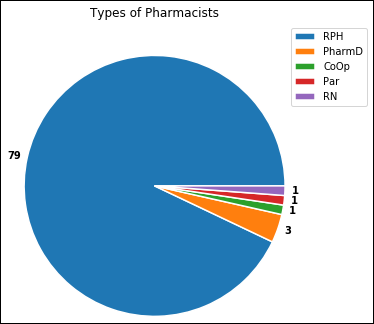

In [32]:
# fig, ax = plt.subplots()
fig = plt.figure(linewidth=2, edgecolor='k')
ax = fig.add_subplot(111)
# fig.add_axes((0.5, 0, 1, 1)).set_zorder(0)
# explode = [0] + ([0.05] * (len(pharm_vc)-1))

patches1, texts1 = ax.pie(pharm_vc, radius=1.5, wedgeprops={'edgecolor': 'w', 'linewidth': 1.5, 'linestyle': 'solid'}
      , textprops={'color': 'k', 'fontsize': 10, 'fontweight': 'bold'}, labels=pharm_vc, labeldistance=1.05
      )
# [p.set_zorder(10) for p in patches1]

ax.legend(labels=pharm_vc.index, loc="upper right", bbox_to_anchor=(1.50, 1.25))

plt.title('Types of Pharmacists', y=1.25)
# plt.tight_layout()
plt.show()

### Numpy Data

In [33]:
a = np.arange(15)
a

array([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14])

In [34]:
a = np.arange(15).reshape(3,5)
a

array([[ 0,  1,  2,  3,  4],
       [ 5,  6,  7,  8,  9],
       [10, 11, 12, 13, 14]])

In [35]:
a.shape

(3, 5)

In [36]:
a.ndim

2

In [37]:
a.dtype.name

'int32'

In [38]:
type(a)

numpy.ndarray

In [39]:
np.array(range(10))

array([0, 1, 2, 3, 4, 5, 6, 7, 8, 9])

In [40]:
np.zeros( (2,3) )

array([[0., 0., 0.],
       [0., 0., 0.]])

In [41]:
np.ones( (2,3,4) )

array([[[1., 1., 1., 1.],
        [1., 1., 1., 1.],
        [1., 1., 1., 1.]],

       [[1., 1., 1., 1.],
        [1., 1., 1., 1.],
        [1., 1., 1., 1.]]])

In [42]:
np.empty( (2,3) )

array([[0., 0., 0.],
       [0., 0., 0.]])

In [43]:
np.arange(10, 30, 5)

array([10, 15, 20, 25])

In [44]:
np.arange(0,2,0.3)

array([0. , 0.3, 0.6, 0.9, 1.2, 1.5, 1.8])

In [45]:
np.linspace(0,2,9)

array([0.  , 0.25, 0.5 , 0.75, 1.  , 1.25, 1.5 , 1.75, 2.  ])

In [46]:
from numpy import pi

x = np.linspace(0, 2*pi, 100)
f = np.sin(x)

#### Operations

In [47]:
a = np.array([20,30,40,50])
b = np.arange(4)
b

array([0, 1, 2, 3])

In [48]:
c = a - b
c

array([20, 29, 38, 47])

In [49]:
b**2

array([0, 1, 4, 9], dtype=int32)

In [50]:
A = np.array( [[1,1], 
               [0,1]] )
B = np.array( [[2,0], 
               [3,4]] )

In [51]:
A * B  # elementwise product

array([[2, 0],
       [0, 4]])

In [52]:
A @ B  # matrix product

array([[5, 4],
       [3, 4]])

In [53]:
A.dot(B)  # matrix product

array([[5, 4],
       [3, 4]])

#### Shape Manipulation

In [54]:
a = np.floor( 10 * np.random.random((3,4)) )
a

array([[6., 6., 8., 1.],
       [8., 9., 6., 8.],
       [6., 3., 2., 2.]])

In [55]:
a.reshape(6,2)

array([[6., 6.],
       [8., 1.],
       [8., 9.],
       [6., 8.],
       [6., 3.],
       [2., 2.]])

In [56]:
a.shape

(3, 4)

In [58]:
a.ravel()

a.reshape(6,2)

array([[6., 6.],
       [8., 1.],
       [8., 9.],
       [6., 8.],
       [6., 3.],
       [2., 2.]])

In [59]:
a.T  # transpose of original array

array([[6., 8., 6.],
       [6., 9., 3.],
       [8., 6., 2.],
       [1., 8., 2.]])

In [60]:
a.T.shape

(4, 3)

In [62]:
a.resize((2,6))
a

array([[6., 6., 8., 1., 8., 9.],
       [6., 8., 6., 3., 2., 2.]])

In [63]:
a.shape

(2, 6)

In [73]:
a.reshape(4,-1)  # -1 calculates other column automatically

array([[6., 6., 8.],
       [1., 8., 9.],
       [6., 8., 6.],
       [3., 2., 2.]])